In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

from astropy.io import fits
import matplotlib as m
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
import tensorflow.keras.backend as K
print(tf.__version__)

from scipy.io import readsav
from scipy.signal import deconvolve
from scipy.ndimage.interpolation import shift

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from intdim_mle import intrinsic_dim_sample_wise, intrinsic_dim_scale_interval
from intdim_mle import repeated, intrinsic_dim_sample_wise_parallel

#TURBO CHARGE YOUR PYTHON -- Make it parallel
import multiprocessing
from joblib import Parallel, delayed

2.1.0


In [2]:
font = 'Helvetica'
params = {'backend': 'tkagg',
          'axes.labelsize': 15,
          'axes.titlesize': 15,
          'font.size': 12,
          'legend.fontsize': 12,
          'font.family': 'sans-serif',
          'font.sans-serif': font,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': True,
          'figure.dpi': 125,
          'lines.linewidth': 1.0,
          'axes.linewidth':1.0,
          'image.interpolation'  : 'nearest',
          'xtick.major.size'     : 5,      # major tick size in points
          'xtick.minor.size'     : 3.5,      # minor tick size in points
          'xtick.major.width'    : 0.5,    # major tick width in points
          'xtick.minor.width'    : 0.3,    # minor tick width in points
          'axes.spines.top': False,
          'axes.spines.right':False,
          'xtick.top': False,
          'ytick.right': False,
          'axes.formatter.useoffset': False
}
m.rcParams.update(params)
m.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

m.rcParams['mathtext.fontset'] = 'custom'
m.rcParams['mathtext.rm'] = font
m.rcParams['mathtext.it'] = font+':italic'
m.rcParams['mathtext.bf'] = font+':bold'
m.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
fSizeAxisLabel = 10

In [211]:
def convolve(signal, filterProfile): 

    return np.convolve(signal, filterProfile)

def customLoss(yTrue, yPred):

    weights1 = K.constant(weights)
    return K.mean(K.square(yTrue - yPred) * weights1)

def customLoss_MP(yTrue, yPred):

    weights1 = K.constant(weights_MP)
    return K.mean(K.square(yTrue - yPred) * weights1)

def customLoss1(yTrue, yPred):

    weights11 = K.constant(weights[0:40])
    return K.mean(K.square(yTrue - yPred) * weights11)

In [660]:
def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    print(hdul.header)
    return spectrum 

def build_simple_model1():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  waveNumd  = 100
  model = keras.Sequential([
    layers.Conv1D(50, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(40, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(25, (3,),
        activation='relu'),
    layers.Conv1D(15, (4,),
        activation='relu'),
    layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(40,activation=tf.nn.relu),
    layers.Dense(40,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss=customLoss,
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  waveNumd  = dl
  model = keras.Sequential([
    layers.Conv1D(15, (3,),
        activation='relu', strides=1, input_shape=[waveNumd, 1]),
    layers.Conv1D(30, (5,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.Conv1D(25, (3,),
        activation='relu'),
    #layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    #layers.Dense(30,activation=tf.nn.relu),
    layers.Dense(30,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model2():
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 3
    waveNumd  = dl
    y1 = layers.Input(shape=[dl,1])
    y = layers.Conv1D(5, (kSzConv1D, ), activation='relu')(y1)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    #y = layers.Dense(100,activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    #y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5, (kSzConv1D, ), activation='relu')(y)
    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(waveNumd, activation=tf.nn.relu)(y)
    y2 = layers.Add()([y, y1[:,  :, 0]])
    y = layers.Dense(dl, activation=tf.nn.relu)(y2)

    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    
    x = layers.Dense(dl, activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=1.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss='mean_squared_error', optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

def build_conv_model_MP(waveNumd, ratio):
    '''
    build the NN needed for the problem accomodating a single
    convolutional layer and two densely connected hidden layer
    '''
    kSzConv1D = 3
    # waveNumd  = 40
    
    y1 = layers.Input(shape=[int(waveNumd/ratio),1])
    y = layers.Conv1D(5,  (kSzConv1D, ))(y1)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (kSzConv1D, ))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.MaxPooling1D(2)(y)
    #y = layers.Conv1D(20, (kSzConv1D,), activation='relu')(y)
    #y = layers.MaxPooling1D(2)(y)
    # y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    # y = layers.Dense(waveNumd,activation='relu')(y)
    #y = layers.UpSampling1D()(y)
    #y = layers.Conv1D(20,(kSzConv1D,), activation='relu')(y)
    # y = layers.Dropout(0.2)(y)
    # y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10,(kSzConv1D,))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5,(kSzConv1D,))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    # layers.GlobalAveragePooling1D(),
    # y = layers.Flatten()(y)
    y = layers.Flatten()(y)
    # y = layers.Dense(waveNumd, activation='sigmoid')(y)
    x = layers.Dense(waveNumd,activation='linear')(y)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model2 = keras.models.Model(inputs=y1, outputs=x)
    model2.compile(loss=customLoss_MP,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model2

def build_dense_model():
    waveNumd  = 100
    numDense1 = 256
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Flatten()(y1)
    y = layers.Dense(numDense1,activation='relu')(y)
    #y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    #y = layers.Dense(256,activation='relu')(y)
    #y = layers.Flatten()(y)
    y = layers.Dense(waveNumd,activation='sigmoid')(y)
    y = layers.Add()([y,y1[:,:,0]])
    x = layers.Dense(waveNumd,activation='linear')(y)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss=customLoss,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model 


def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    return spectrum 

def radial_dist(sizeX,sizeY):
    '''Prepare a flat array of the radial distance of the pixel
    from the optical center of the system -- used for removing 
    uncorrected blueshifts
    '''
    
    centerX = sizeX/2
    centerY = sizeY/2
    
    radialDistances = np.zeros((sizeX,sizeY))
    
    for ii in range(sizeX):
        for jj in range(sizeY):
            radialDistances[ii,jj] = (centerX-ii)**2 + (centerY-jj)**2
    
    radialDistances = np.reshape(radialDistances,(sizeX*sizeY))
    
    return radialDistances


def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec

    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250,figsize=(8,6))
    #plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='Convolved spectrum')
    plt.plot(wavescale,profile_FP2,'b.--',label='Original spectrum')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred spectrum')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.grid(alpha=0.5)
    plt.savefig('Figures/Comparison_FISS.png',transparent=True)
    plt.show()


def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp


def Gaussian(x,mu,sigma):
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)


def produce_FP_transmission_peak(dlambda, lambda_0, Nlambda, FPnum, wavelength):
    '''
    Create FP transmission profile from the saved IBIS files
    
    Inputs:
    -- dlambda -- spectral resolution 
    -- lambda_0 -- offset wavelength
    -- Nlambda -- number of wavelengths
    -- FPnum   -- which Fabry Perot to be used 
    -- wavelength -- [6563, 8542] which wavelength the IBIS transmission 
                    profiles to be loaded from
    
    Outputs:
    -- filterProfile -- Transmission profile to be used
    '''
    wave_I = np.linspace((lambda_0-dlambda*Nlambda/2),(lambda_0+dlambda*Nlambda/2),num=Nlambda)
    ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
    wave          = np.linspace(-24,24,num=48001)
    if wavelength == 6563:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_6563']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_6563'] 
    if wavelength == 8542:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_8542']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_8542']
    filterProfile = np.interp(wave_I,wave,t)
    return filterProfile

def produce_custom_FP_transmission(dlambda, lambda_0, Nlambda, FPnum, wavelength):
    '''
    Create FP transmission profile from the saved IBIS files
    
    Inputs:
    -- dlambda -- spectral resolution 
    -- lambda_0 -- offset wavelength
    -- Nlambda -- number of wavelengths
    -- FPnum   -- which Fabry Perot to be used 
    -- wavelength -- [6563, 8542] which wavelength the IBIS transmission 
                    profiles to be loaded from
    
    Outputs:
    -- filterProfile -- Transmission profile to be used
    -- wave_I - wavelength scale to be used
    '''
    wave_I = np.linspace((lambda_0-dlambda*Nlambda/2),(lambda_0+dlambda*Nlambda/2),num=Nlambda)
    ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
    wave          = np.linspace(-24,24,num=48001)
    if wavelength == 6563:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_6563']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_6563'] 
    if wavelength == 8542:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_8542']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_8542']
    filterProfile = np.interp(wave_I,wave,t)
    return wave_I, filterProfile



## Preview of some of the FISS data.

Shape of haData is 100 256 512


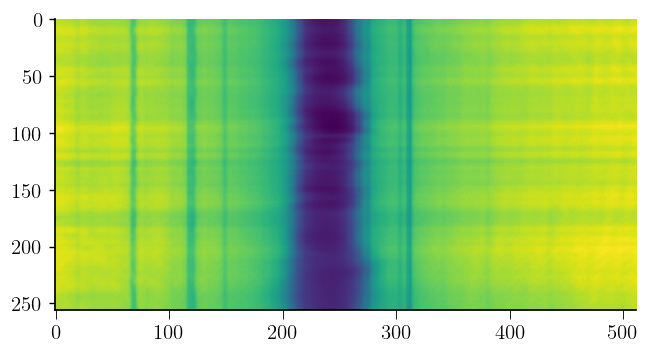

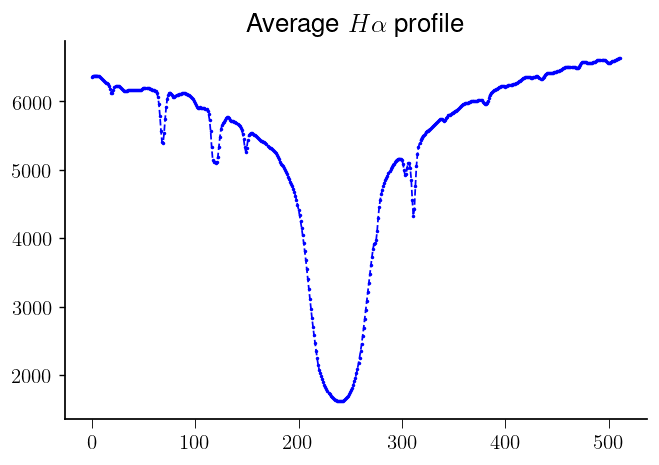

Shape of caData is 100 250 502


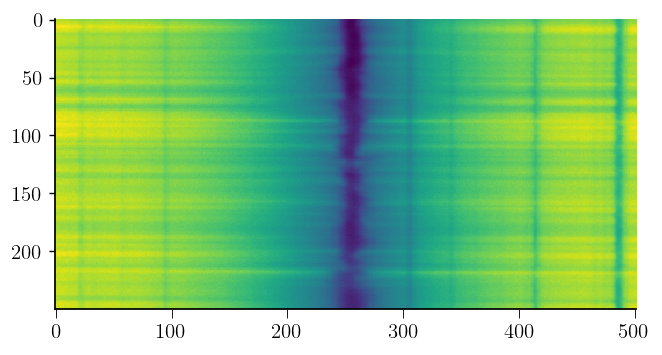

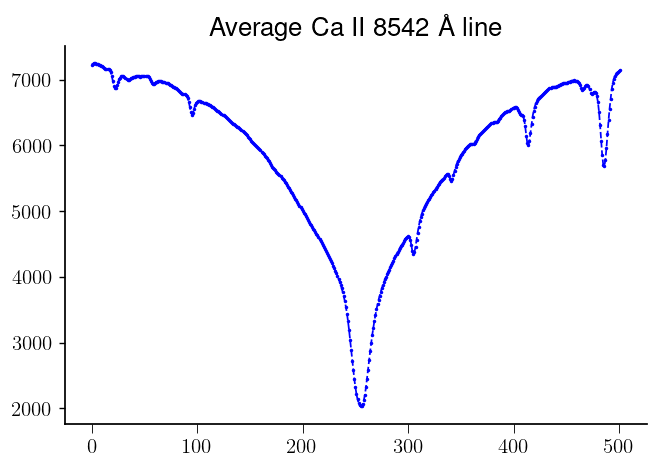

In [265]:
haData = load_spectral_profiles('','FISS_20160622_174421_A1.fts')
haSpectralRes = 0.0190416632507
print('Shape of haData is %d %d %d'%haData.shape)
plt.imshow(haData[0,:,:])
plt.show()

plt.title('Average $H\\alpha$ profile')
plt.plot(np.mean(haData[:,:,:],axis=(0,1)), 'b.--', markersize=2)
plt.show()

caData = load_spectral_profiles('','FISS_20160622_175412_B1.fts')
caSpectralRes = 0.0256741359106
print('Shape of caData is %d %d %d'%caData.shape)
plt.imshow(caData[0,:,:])
plt.show()

plt.title('Average Ca II 8542 \AA~line')
plt.plot(np.mean(caData[:,:,:],axis=(0,1)), 'b.--', markersize=2)
plt.show()

## Convolve the FISS data with some PSFs

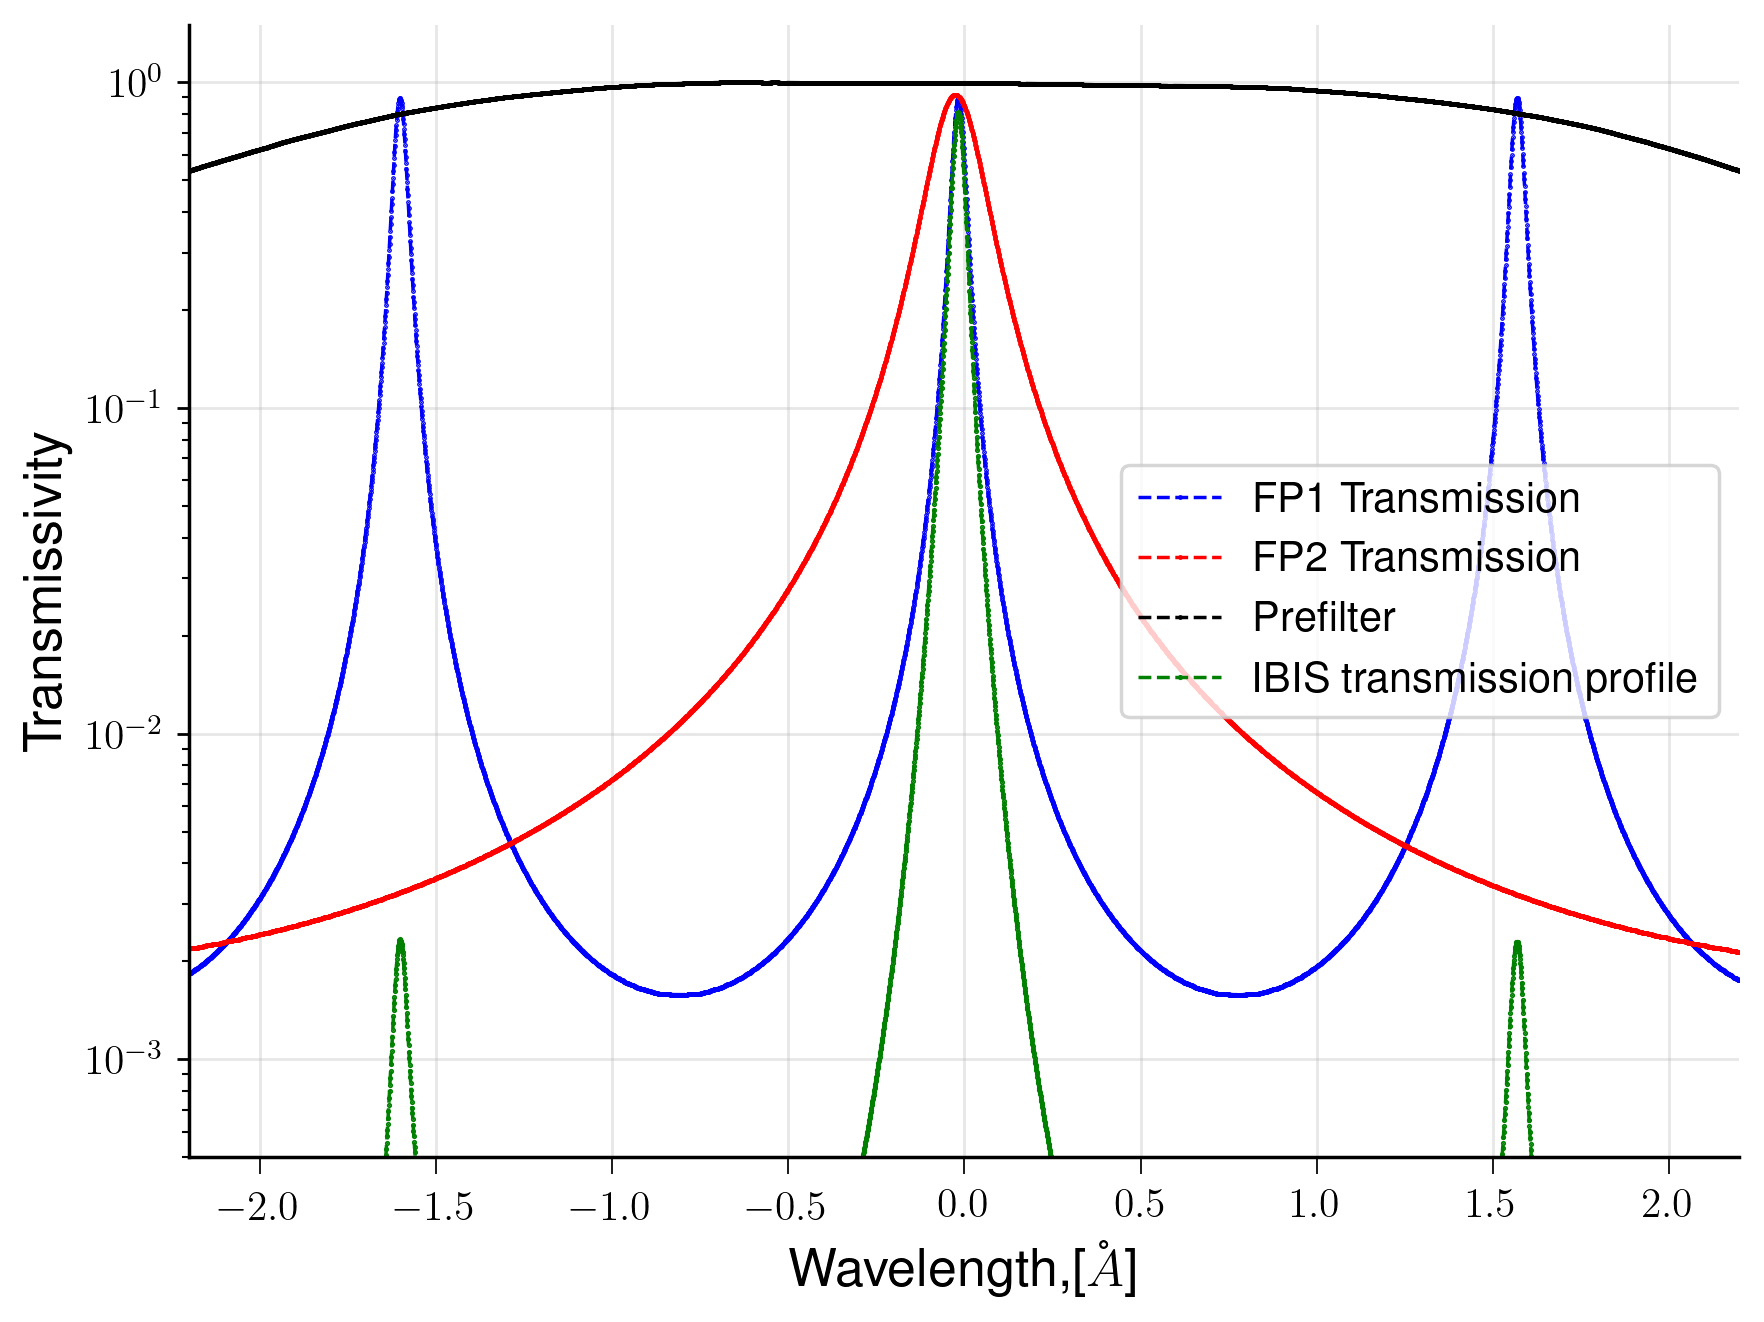

In [6]:
wave = np.linspace(-24, 24, num=48001)
ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
pf_ha = readsav('H-alpha_IBIS_Prefilter.sav')
pf   = readsav('prefilter.8542.reference.profile.Apr2015.sav')
pf_f = np.interp(wave, pf['PREFILT8542_REF_WVSCL'], pf['PREFILT8542_REF_MAIN'], left=0, right=0)
m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}
markersize1 = .75
plt.figure(figsize=(8, 6), dpi=250)

plt.plot(wave, ab['ibis_fp1_profile_8542'], 'b.--', label='FP1 Transmission', markersize=markersize1)
plt.plot(wave, ab['ibis_fp2_profile_8542'], 'r.--', label='FP2 Transmission', markersize=markersize1)
plt.plot(wave, pf_f,'k.--',label='Prefilter', markersize=markersize1)
plt.plot(wave, ab['ibis_fp1_profile_8542']*ab['ibis_fp2_profile_8542']*pf_f, 'g.--',
         markersize=1, label='IBIS transmission profile')
plt.legend()
plt.yscale('log')
plt.ylabel('Transmissivity', **csfont)
plt.ylim(5e-4, 1.5)
plt.xlabel('Wavelength,[$\\AA$]', **csfont)
plt.xlim(-2.2, 2.2)
plt.grid(alpha=0.3)
plt.savefig('Figures/FP_transmission_profile.png', transparent=True)
plt.show()

np.savez("Fig_3_1.npz", wave=wave, fp1 = ab['ibis_fp1_profile_8542'],
         fp2=ab['ibis_fp2_profile_8542'], pf_f=pf_f)
np.load("Fig_3_1.npz")

### Convolve the whole FISS FOV

NameError: name 'a' is not defined

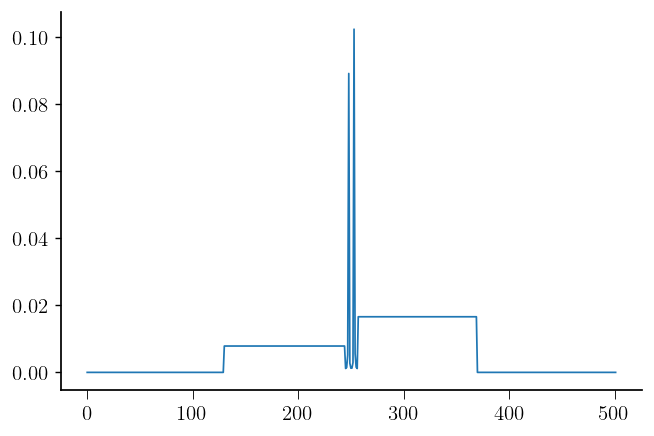

<Figure size 1200x800 with 0 Axes>

In [7]:
Nlambda      = 502
dlambda      = 0.024
trans_filter = produce_FP_transmission_peak(4,0,Nlambda,2,6563)
wave         = np.linspace(-.5*Nlambda*dlambda,.5*Nlambda*dlambda,num=Nlambda)

trans_filter[0:130] = 0
trans_filter[370:] = 0

trans_filter_total = np.sum(trans_filter)

plt.plot(trans_filter)
#plt.grid()
#plt.yscale('log')
#plt.show()
plt.figure(dpi=200)
b = np.convolve(a[0,0,:],trans_filter/trans_filter_total,mode='same')
print("Shape of b is %d"%b.shape)
print("Shape of a[0,0,:] is %d"%a[0,0,:].shape)
plt.plot(wave,(a[0,0,:]),'r.--',label='Genuine')
plt.plot(wave,(b[0:Nlambda]),'g.--',label='Convolved')
plt.legend()
plt.grid()
plt.show()

### Convolve the Ha and Ca data with the wide FP Transmission profile

502
(100, 250, 502)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using TkAgg, which is a non-GUI backend, so cannot show the figure.


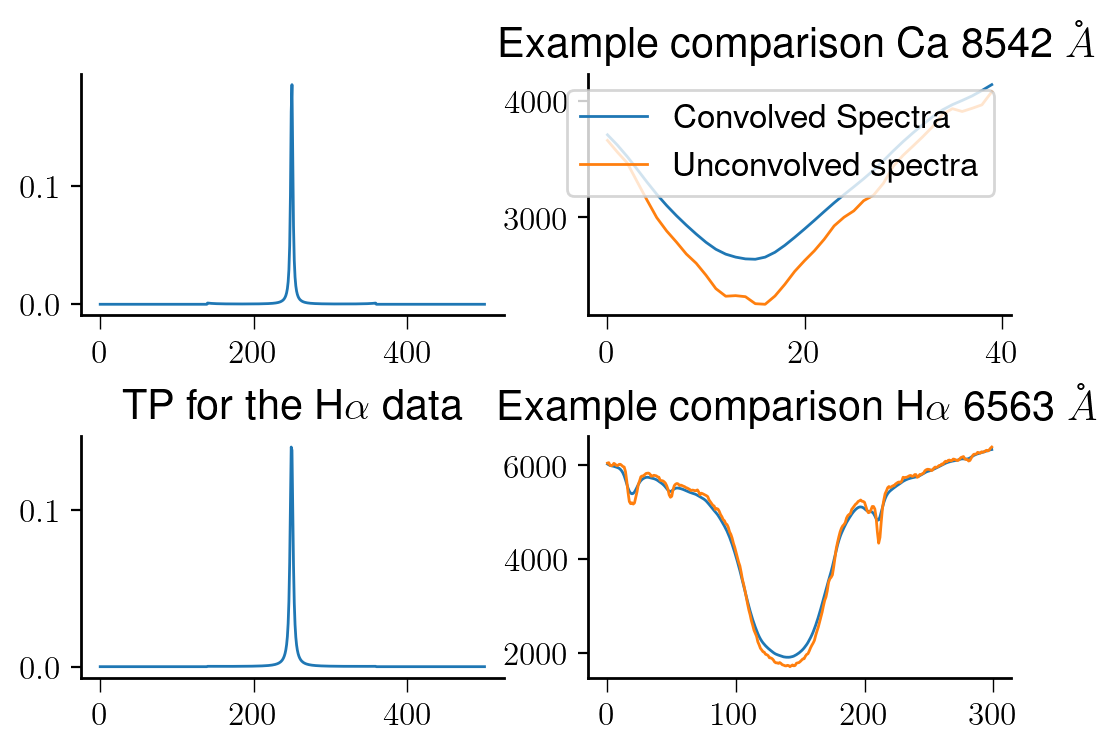

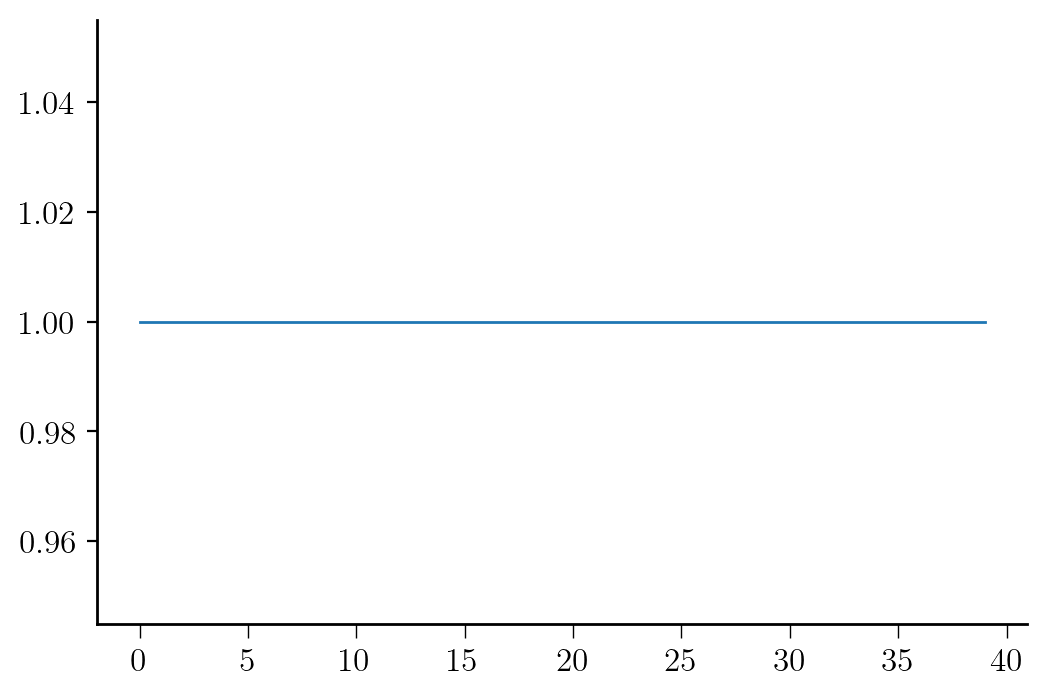

In [8]:
Nlambda_ca = caData.shape[2]
Nx_ca      = caData.shape[0]
Ny_ca      = caData.shape[1]

print(Nlambda_ca)
print(caData.shape)

lStart = 240
lEnd   = 280
dl     = lEnd - lStart

fig, ax = plt.subplots(nrows=2, ncols=2, dpi=200)
fig.subplots_adjust(hspace=.5)

TProfile = produce_FP_transmission_peak(caSpectralRes, 0, Nlambda_ca, 2, 6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)
ax[0, 0].plot(TProfile)

caConvolved = np.zeros((Nx_ca, Ny_ca, Nlambda_ca))

for ii in range(Nx_ca):
    for jj in range(Ny_ca):
        caConvolved[ii, jj, :] = np.convolve(caData[ii, jj, :], TProfile, mode='same')

ax[0,1].set_title('Example comparison Ca 8542 $\AA$')
ax[0,1].plot(caConvolved[80, 20, lStart:lEnd], label='Convolved Spectra')
ax[0,1].plot(caData[80, 20, lStart:lEnd], label='Unconvolved spectra')
ax[0,1].legend()

Nlambda_ha = haData.shape[2]
Nx_ha      = haData.shape[0]
Ny_ha      = haData.shape[1]


TProfile = produce_FP_transmission_peak(haSpectralRes,0,Nlambda,2,6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)


ax[1,0].plot(TProfile)
ax[1,0].set_title('TP for the H$\\alpha$ data')

haConvolved = np.zeros((Nx_ha,Ny_ha,Nlambda_ha))

for ii in range(Nx_ha):
    for jj in range(Ny_ha):
        haConvolved[ii,jj,:] = np.convolve(haData[ii,jj,:],TProfile,mode='same')

lStart_Ha = 100
lEnd_Ha   = 400
dl_Ha     = lEnd - lStart
ax[1, 1].set_title('Example comparison H$\\alpha$ 6563 $\AA$')
ax[1, 1].plot(haConvolved[80, 20, lStart_Ha:lEnd_Ha], label='Convolved spectra')
ax[1, 1].plot(haData[80, 20, lStart_Ha:lEnd_Ha], label='Unconvolved spectra')

fig.show()

fig1 = plt.figure(dpi=200)

mean_profile_8542 = (np.mean(np.mean(caData,axis=0),axis=0))[lStart:lEnd]

power_weigths     = 0
norm_const        = mean_profile_8542[0]**power_weigths
weights           = norm_const/mean_profile_8542**power_weigths

plt.plot(weights)
plt.show()

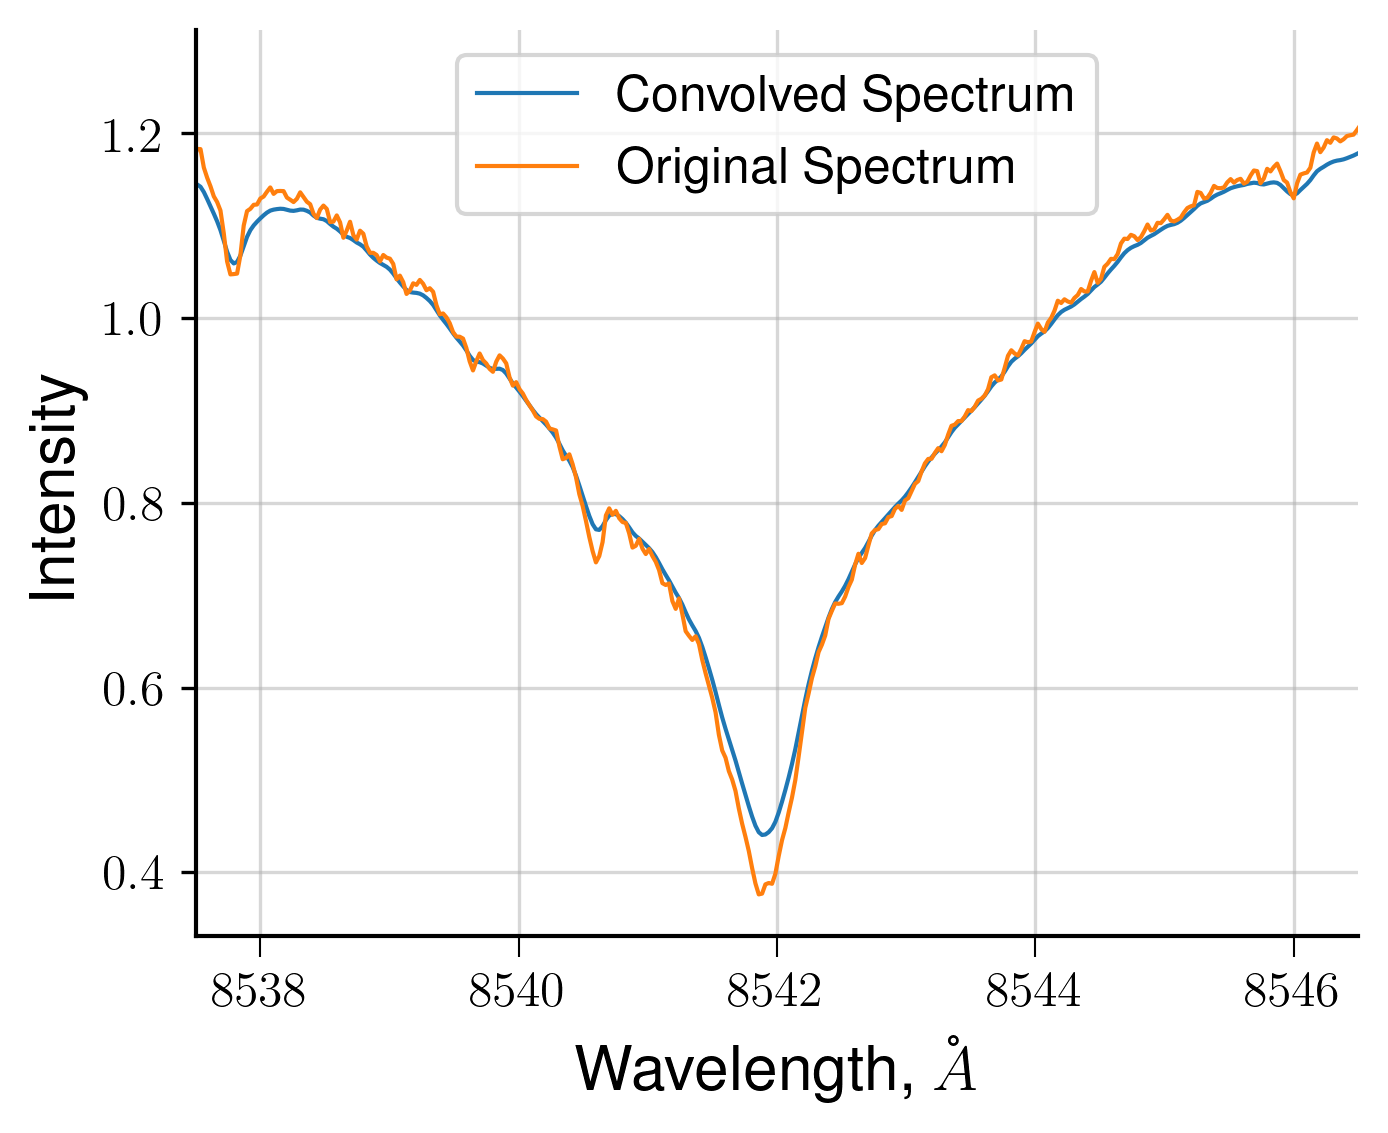

In [9]:
plt.figure(dpi=300,figsize=(5,4))
#plt.title('Example comparison Ca 8542 $\AA$')

norm   = 6000
m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}
wave   = np.linspace(caSpectralRes*502/2,caSpectralRes*502/(-2),num=502)+8542
plt.plot(wave,caConvolved[80,20,:]/norm,label='Convolved Spectrum')
plt.plot(wave,caData[80,20,:]/norm,label='Original Spectrum')
plt.xlabel('Wavelength, $\\AA$',**csfont)
plt.ylabel('Intensity',**csfont)
plt.xlim(8537.5,8546.5)
plt.grid(alpha=0.5)
plt.legend()
plt.savefig('Figures/CA_FISS_Example_conv11.png',transparent=True)
plt.show()

# Build and train the model

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 45, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 43, 5)        20          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_12 (MaxPooling1D) (None, 21, 5)        0           conv1d_24[0][0]                  
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 19, 10)       160         max_pooling1d_12[0][0]           
____________________________________________________________________________________________

The normalization values for original are 5004.53232 and convolved images 5000.971318278386


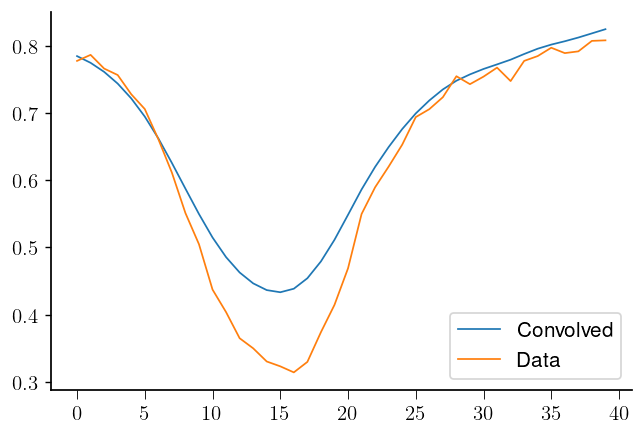

In [284]:
norm_data = np.mean(caData[:,:,200],axis=(0,1))
norm_conv = np.mean(caConvolved[:,:,200],axis=(0,1))
print(f'The normalization values for original are {norm_data} and convolved images {norm_conv}')

caData_Conv_norm = (caConvolved / norm_conv)[:,:,lStart:lEnd] 
caData_norm      = (caData / norm_conv)[:,:,lStart:lEnd] 
   
plt.plot(caData_Conv_norm[90,90,:], label='Convolved')
plt.plot(caData_norm[90,90,:], label='Data')
plt.legend()
plt.show()

In [45]:
model1 = build_conv_model2()
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 43, 5)        20          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 21, 5)        0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 19, 10)       160         max_pooling1d[0][0]              
______________________________________________________________________________________________

In [157]:
EPOCHS = 10000
optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model1.optimizer = tf.keras.optimizers.Adam(lr=1e-1, beta_1=0.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model1.optimizer = tf.keras.optimizers.SGD(lr=1, nesterov=True)

history = model1.fit(np.reshape(caData_Conv_norm, (int(Nx_ca * Ny_ca), dl, 1)),
                     np.reshape(caData_norm, (int(Nx_ca * Ny_ca), dl)),
                     epochs=EPOCHS, validation_split=0.20, verbose=2)

'''
history = model.fit(np.reshape(caData_Conv_norm[:,:,lStart:lEnd],(int(Nx_ca*Ny_ca),dl,1)),
                    np.reshape(caData_norm[:,:,lStart:lEnd],(int(Nx_ca*Ny_ca),dl)),
                    epochs=EPOCHS,validation_split=0.25 , verbose=2)
'''

ValueError: Error when checking input: expected input_1 to have shape (45, 1) but got array with shape (40, 1)

235 280
(100, 250, 45)


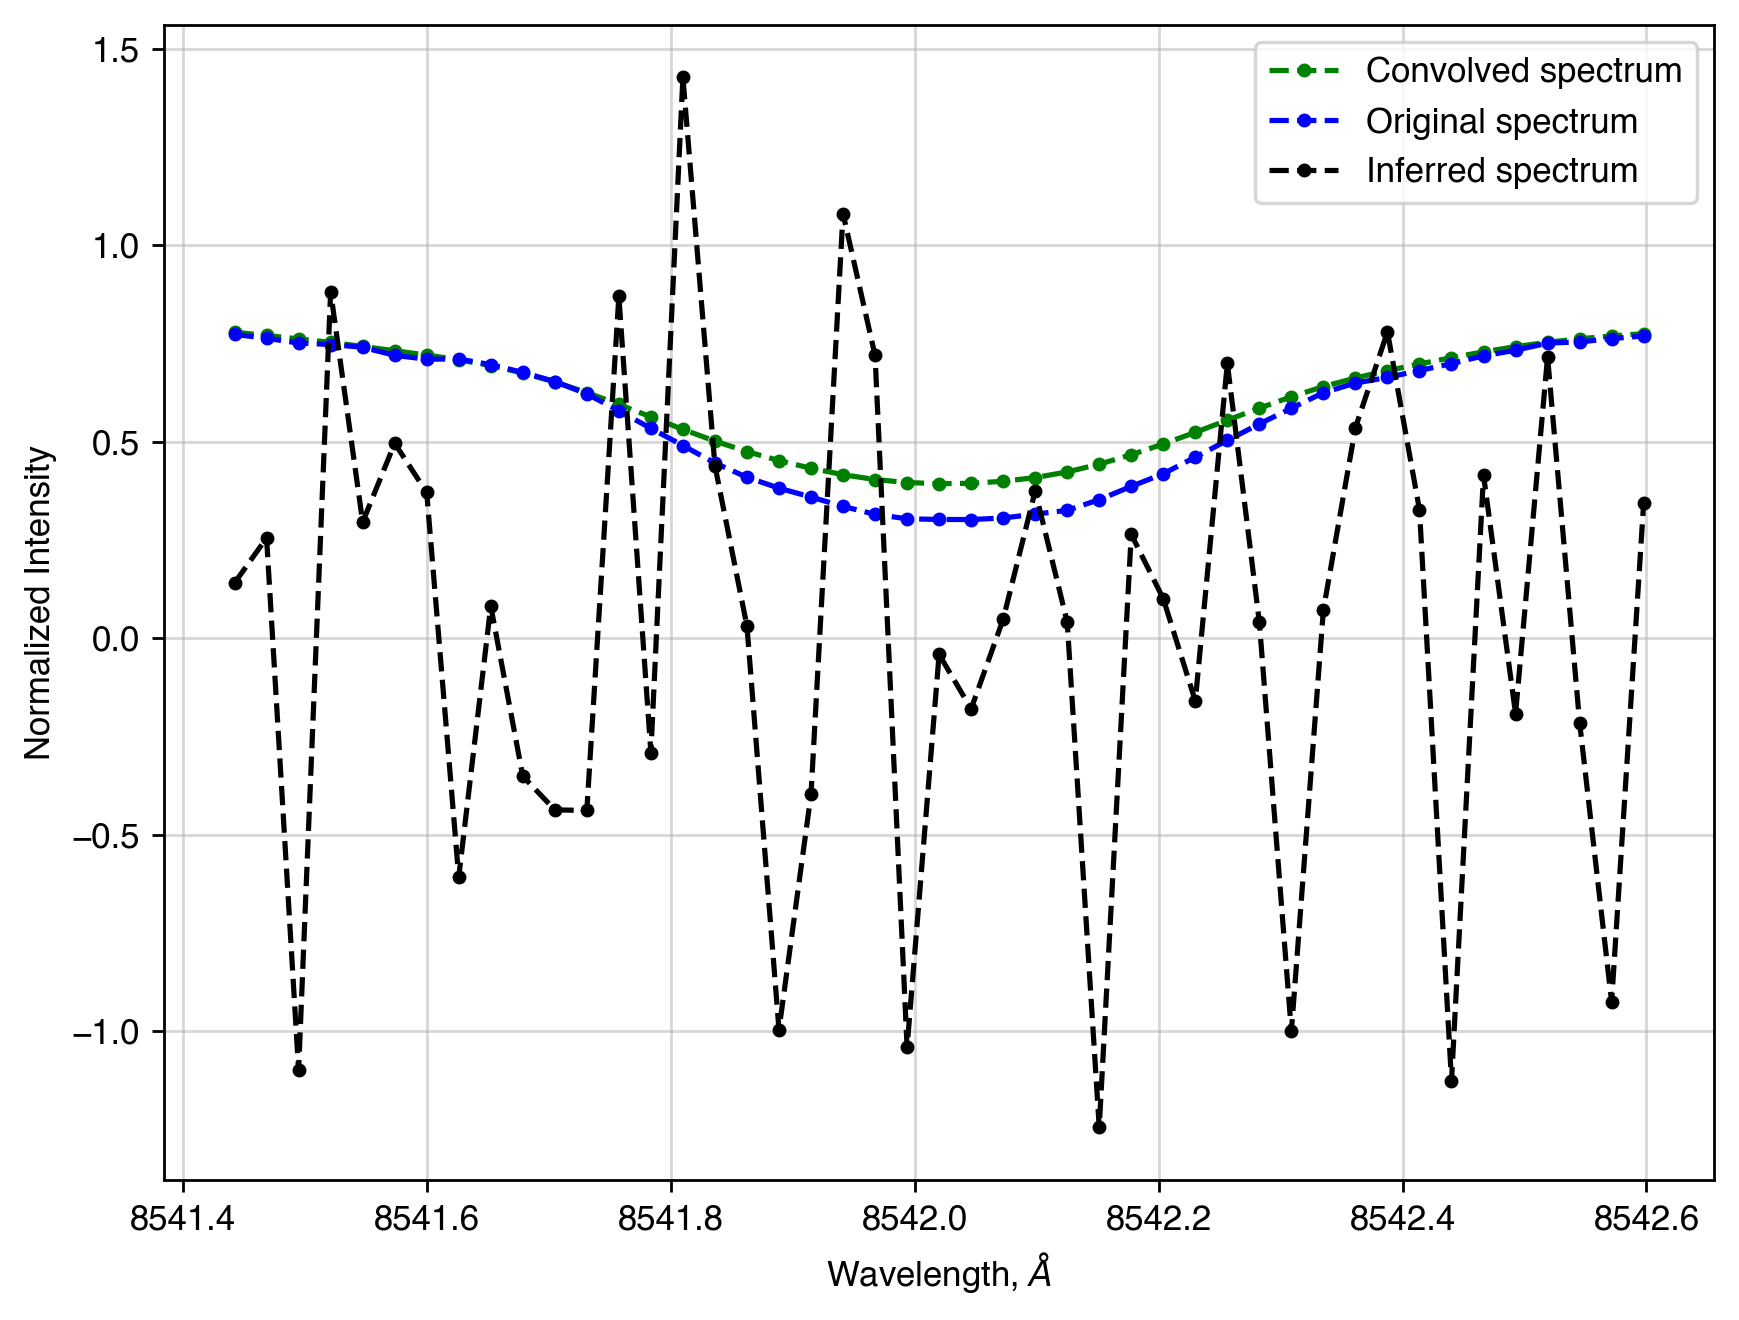

In [46]:
prevNum  = 4
prevNumy = 21
delta    = 2
print(lStart,lEnd)
#im       = model.predict(train_set[:,:,:])
#plt.figure(dpi=200)
#plt.imshow(np.reshape(train_set[:,30,0],(968,968)))
#plt.show()
#plt.figure(dpi=200)Z
#plt.imshow(np.reshape(im[:,30],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(truth_set[:,30],(968,968)))
#plt.show()

print(caData_Conv_norm.shape)

res = model1.predict(np.reshape(caData_Conv_norm[prevNum, prevNumy, :],(1, 45, 1)))

wavescale = np.linspace(-1* dl * caSpectralRes/2 + 8542.02, dl * caSpectralRes/2 + 8542.02, num=dl)
plot_spec_profile_comparison(wavescale, caData_Conv_norm[prevNum, prevNumy, :],
                             caData_norm[prevNum, prevNumy, :], res[0, :])
np.savez('Fig2_2_data.npz', dl, caSpectralRes, caData_norm, caData_Conv_norm, prevNum, prevNumy,
         res, wavescale)

In [283]:
fSizeAxisLabel = 10

caData_test = load_spectral_profiles('', 'FISS_20160622_174907_B1.fts')

caConvolved_test = np.zeros((Nx_ca,Ny_ca, 502))
 
TProfile = produce_FP_transmission_peak(caSpectralRes, 0, Nlambda_ca, 2, 6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)
ax[0, 0].plot(TProfile)
    

for ii in range(Nx_ca):
    for jj in range(Ny_ca):
        caConvolved_test[ii, jj, :] = np.convolve(caData_test[ii, jj, :], TProfile, mode='same')
        
caConvolved_test = np.reshape(caConvolved_test, (Nx_ca*Ny_ca, 502, 1))
caData_test      = np.reshape(caData_test, (Nx_ca*Ny_ca, 502))

caData_test1      = caData_test[:, lStart:lEnd]
caConvolved_test1 = caConvolved_test[:, lStart:lEnd, :]

#plt.plot(caData_test1[200,:]/norm_conv)
#plt.plot(caConvolved_test[200,:,0]/norm_conv)
#plt.show()
print(norm_conv)
evaluation = model1.evaluate(np.reshape(caData_Conv_norm, (int(Nx_ca*Ny_ca), dl, 1)),
                            np.reshape(caData_norm, (int(Nx_ca*Ny_ca), dl)))

evaluation = model1.evaluate(caConvolved_test1/norm_conv, caData_test1/norm_data, verbose=1)

start = time.process_time()

predict    = model1.predict(caConvolved_test1/norm_conv,verbose=1)
print("The elapsed time for 1M Pixel inversion is: %6.2f seconds"%(time.process_time() - start))
print(predict.shape)
m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}

wavex = np.linspace(np.amin(predict)-.05,np.amax(predict),num=1000)


plt.figure(dpi=200,figsize=(8,6))
plt.xlim(0.25, 0.65)
plt.ylim(0.25, 0.65)

plt.plot(np.amin(caData_test1/norm_conv,axis=1), np.amin(predict,axis=1), 'r.'
         ,alpha=0.022)
plt.plot(0,0,'r.',label='Deconvolved')
plt.plot(np.amin(caData_test1/norm_conv,axis=1),np.amin(caConvolved_test1/norm_conv,axis=1)
         ,'g.',alpha=0.022)
plt.plot(0,0,'g.',label='Convolved')
plt.plot(wavex,wavex,'k--',label='1:1 line')

#np.savez('Fig2_3.npz', caData_test1, norm_conv, predict, caConvolved_test1, wavex)

plt.xlabel('Original core intensity', **csfont, fontsize = fSizeAxisLabel)
plt.ylabel('Predicted core intensity', **csfont, fontsize = fSizeAxisLabel)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('Figures/Linecore_int_int.png',transparent=True)
plt.show()

5000


NameError: name 'model1' is not defined

237 277
235 280
(25000, 0)


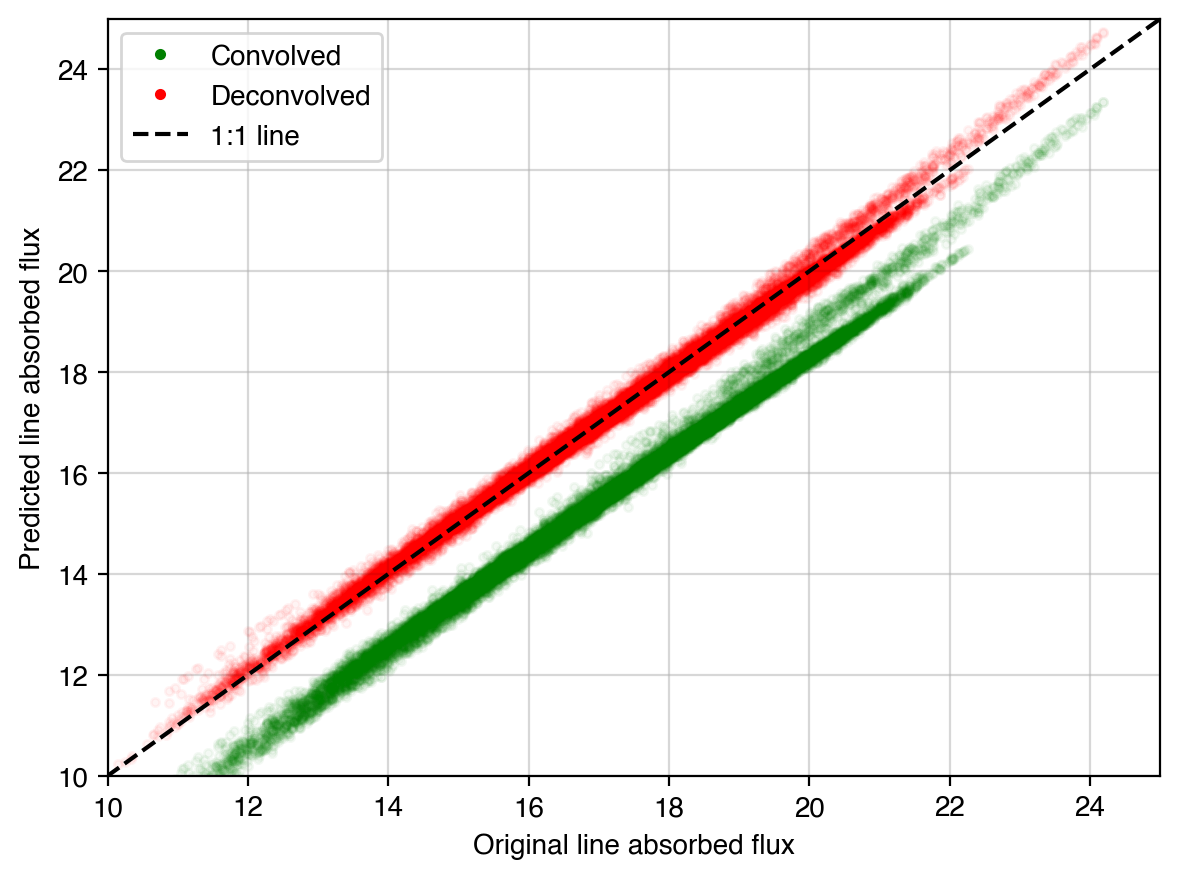

In [205]:
print(lStart1,lEnd1)
print(lStart,lEnd)
print(caData_test1[:,lStart1:lEnd1].shape)

x_min = 10
x_max = 25

m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}
wavex = np.linspace(0,200,num=1000)
plt.figure(dpi=200,figsize=(6,4.5))
plt.xlim(x_min,x_max)
plt.ylim(x_min,x_max)

plt.plot(45-np.sum(caData_test1/norm_conv,axis=1), 45-np.sum(predict,axis=1),
         'r.', alpha=0.042)

plt.plot(45 - np.sum(caData_test1/norm_conv,axis=1),
         45 - np.sum(caConvolved_test1/norm_conv,axis=1), 'g.', alpha=0.042)

plt.plot(0, 0, 'g.', label='Convolved')
plt.plot(0, 0, 'r.', label='Deconvolved')

plt.plot(wavex, wavex, 'k--', label='1:1 line')


plt.xlabel('Original line absorbed flux',**csfont,fontsize = fSizeAxisLabel)
plt.ylabel('Predicted line absorbed flux',**csfont,fontsize = fSizeAxisLabel)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('Figures/Linecore_flux_flux.png',transparent=True)
plt.show()

In [549]:
caDataHDU = fits.PrimaryHDU(caData_test1/norm_conv)
caDataHDU.writeto('caData_original.fits')

caDataConvHDU = fits.PrimaryHDU(caConvolved_test1/norm_conv)
caDataConvHDU.writeto('caData_Conv.fits')
 
resHDU   = fits.PrimaryHDU(predict)
resHDU.writeto('caData_res.fits')

### Calculate dimensionality of the two used above datasets 

In [295]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

N_spectra = 12000

def intrinsic_dim_sample_wise_parallel(X, k=5):
    neighb = NearestNeighbors(n_neighbors=(k + 1)).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 1)
    # print(f'd shape is {d.shape}')
    assert d.shape == (X.shape[0],)
    d = np.mean(d)
    
    intdim_sample = 1 / d
    return intdim_sample

num_k  = 40
k0     = 3
k1     = 2000


k_values = np.logspace(np.log10(k0), np.log10(k1), num=num_k)
intdim_k = []


print(N_spectra, dl1)
data_array = np.zeros((N_spectra, int(dl1)))
conv_data = np.reshape(caData_Conv_norm, (int(Nx_ca * Ny_ca), dl))
orig_data = np.reshape(caData_norm, (int(Nx_ca * Ny_ca), dl))

intdim_original = Parallel(n_jobs=4)(delayed(intrinsic_dim_sample_wise_parallel)(orig_data,
                                                                                 k=int(ii)) 
                            for ii in np.logspace(np.log10(k0), np.log10(k1), num=num_k))

for ii in range(N_spectra):
    data_array_multi[ii, :] = caConvolvedMP[ii,:, 0]/norm_conv

intdim_multiplex = Parallel(n_jobs=4)(delayed(intrinsic_dim_sample_wise_parallel)(conv_data, k=int(ii)) 
                            for ii in np.logspace(np.log10(k0), np.log10(k1), num=num_k))

12000 80


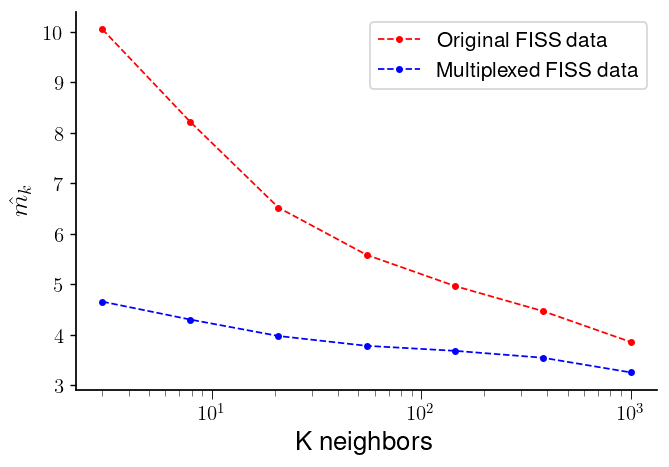

In [294]:
plt.plot(np.logspace(np.log10(k0), np.log10(k1), num=num_k),
         intdim_original, 'r.--', label='Original FISS data')
plt.plot(np.logspace(np.log10(k0), np.log10(k1), num=num_k),
         intdim_multiplex, 'b.--', label='Multiplexed FISS data')

plt.xlabel('K neighbors')
plt.ylabel('$\hat{m_k}$')
plt.xscale('log')
plt.legend()
plt.show()

waves = np.logspace(np.log10(k0), np.log10(k1), num=num_k)
# np.savez('Fig_4_4.npz', intdim_multiplex=intdim_multiplex,
#         intdim_original=intdim_original, waves=waves)

## Convolve with a multi-peak PSF and try to reproduce the line profile

dl is 80
Number of measurements: 40.0


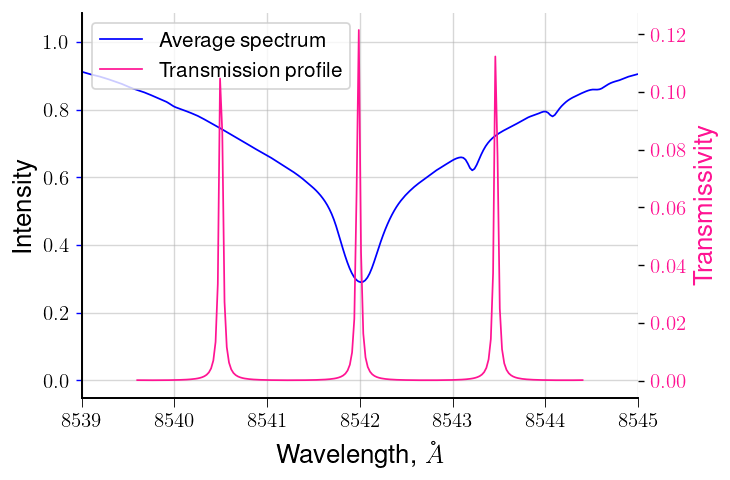

(25000, 40, 1)


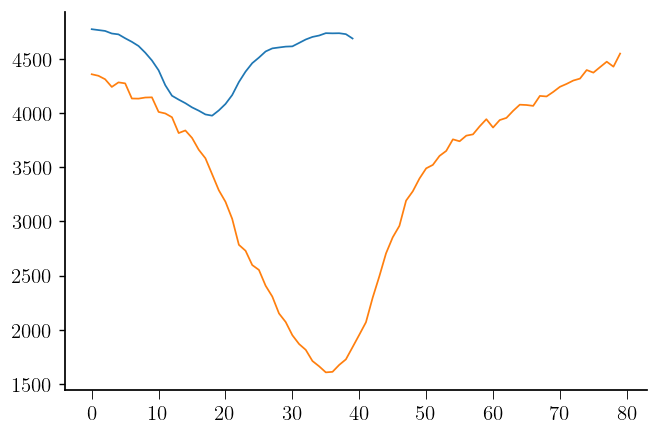

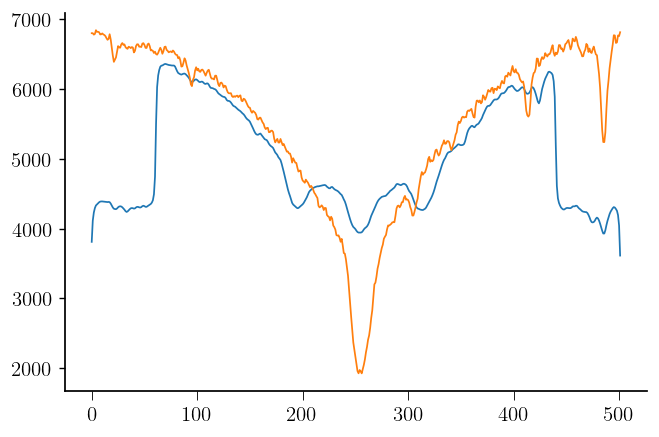

In [237]:
Nlambda      = 200
dlambda      = 0.024
color2 = 'deeppink'
redux_ratio  = 2
norm_conv = 5000

color1 = 'blue'
trans_filter = produce_FP_transmission_peak(caSpectralRes,0,Nlambda,1,8542)
trans_filter = trans_filter / np.sum(trans_filter)
wave         = np.linspace(-.5*Nlambda*dlambda,.5*Nlambda*dlambda,num=Nlambda)+8542.
wave502      = np.linspace(502*dlambda/(-2),502*dlambda/2,num=502)+8541.9


lStart1 = 220
lEnd1   = 300

dl1 = lEnd1 - lStart1

print(f'dl is {dl1}')
print(f'Number of measurements: {dl1/redux_ratio}')

fig1, ax1 = plt.subplots()

fig1.set_dpi=400
fig1.set_size_inches(6,4)
ax1.plot(wave502,np.mean(caData,axis=(0,1))/7000,label='Average spectrum',color=color1)
ax1.tick_params(axis='y', color=color1)
ax1.set_xlabel('Wavelength, $\\AA$')
ax1.set_ylabel('Intensity')
ax1.set_xlim(8542-3, 8542+3)
ax1.plot(0, 0, '-', color=color2, label='Transmission profile')
ax1.grid(alpha=0.5)

ax2 = ax1.twinx() 

ax2.set_ylabel('Transmissivity', color=color2)
ax2.plot(wave, trans_filter, color=color2, label='Transmission profile')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.legend(loc=2)
fig1.tight_layout()
fig1.savefig('Figures/Multiplex_2.png', transparent=True)
plt.show()
plt.close()

np.savez('Fig_4_1.npz', wave502=wave502, caData = np.mean(caData,axis=(0,1))/7000,
         wave=wave, trans_filter=trans_filter)


caConvolvedMP = np.zeros((Nx_ca*Ny_ca, int(dl1/redux_ratio), 1))

caData1       = np.reshape(caData, (Nx_ca*Ny_ca, 502))

for ii in range(Nx_ca*Ny_ca):
    caConvolvedMP[ii, :, 0] = (np.convolve(caData1[ii, :], trans_filter, 
                                         mode='same'))[(lStart1):(lEnd1):(redux_ratio)]

print(caConvolvedMP.shape)
plt.plot(caConvolvedMP[2301, :])
plt.plot(caData1[2301, lStart1:lEnd1])
plt.show()

plt.plot(np.convolve(caData1[ii, :], trans_filter, mode='same'))
plt.plot(caData1[ii, :])
plt.show()

### Compute a narrower comb for the TP computation

dl is 40
Number of measurements: 20.0


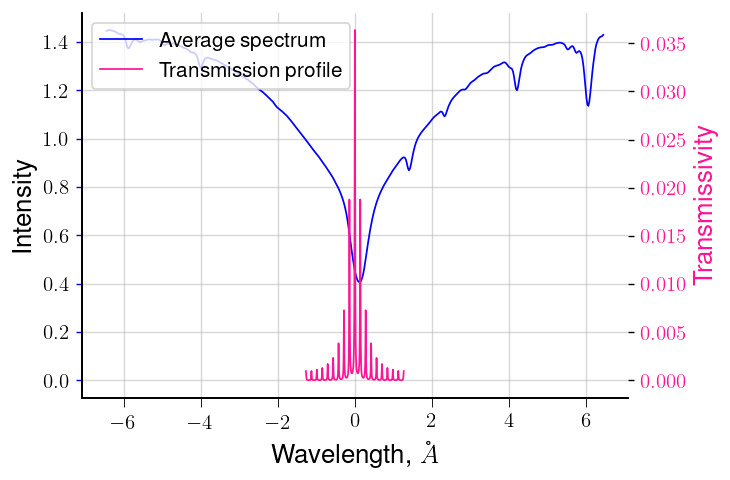

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
(25000, 20, 1)


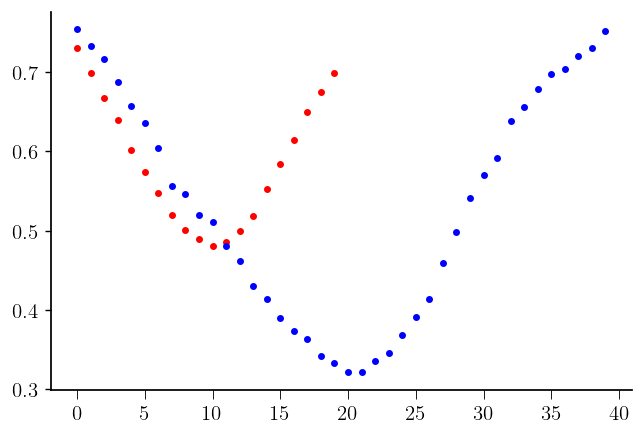

In [763]:
Nlambda      = 200
dlambda      = 0.024
color1 = 'blue'
color2 = 'deeppink'
redux_ratio  = 2
norm_conv    = 5000

with np.load('Instrument_transmission_profile.npz') as a:
    wave_filter  = a['wavescale']*1e10
    trans_filter = a['TP']

    
dwave_filter = (wave_filter[1] - wave_filter[0])
scale_wave_ratio = int(caSpectralRes/dwave_filter)

lStart1 = 235
lEnd1   = 275

# scale_wave_ratio = 10
# 
# trans_filter = produce_FP_transmission_peak(caSpectralRes,0,Nlambda,1,8542)
# wave_filter  = np.linspace(-.5*Nlambda*caSpectralRes/scale_wave_ratio, 
#                            .5*Nlambda*caSpectralRes/scale_wave_ratio, num=Nlambda)+8542.
# 
trans_filter = trans_filter / np.sum(trans_filter)

wave502      = np.linspace(502*caSpectralRes/(-2),
                           502*caSpectralRes/2, num=502) 

wave_data_interp = np.linspace(502*caSpectralRes/(-2),
                               502*caSpectralRes/2,
                               num=caData1.shape[1]*scale_wave_ratio) 

dl1 = lEnd1 - lStart1

print(f'dl is {dl1}')
print(f'Number of measurements: {dl1/redux_ratio}')

fig1, ax1 = plt.subplots()

fig1.set_dpi=400
fig1.set_size_inches(6,4)
ax1.plot(wave502, np.mean(caData1/norm_conv, axis=0), label='Average spectrum', color=color1)
ax1.tick_params(axis='y', color=color1)
ax1.set_xlabel('Wavelength, $\\AA$')
ax1.set_ylabel('Intensity')
# ax1.set_xlim(8542-3, 8542+3)
ax1.plot(0, 0, '-', color=color2, label='Transmission profile')
ax1.grid(alpha=0.5)

ax2 = ax1.twinx() 

ax2.set_ylabel('Transmissivity', color=color2)
ax2.plot(wave_filter, trans_filter, color=color2, label='Transmission profile')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.legend(loc=2)
fig1.tight_layout()
fig1.savefig('Figures/Multiplex_2.png', transparent=True)
plt.show()
plt.close()

#np.savez('Fig_4_1.npz', wave502=wave502, caData = np.mean(caData,axis=(0,1))/7000,
#        wave=wave, trans_filter=trans_filter)



caConvolvedMP = np.zeros((Nx_ca*Ny_ca, int(dl1/redux_ratio), 1))

caData1       = np.reshape(caData, (Nx_ca*Ny_ca, 502))

for ii in range(Nx_ca*Ny_ca):
    if ii%2500 == 0:
        print(f'{ii/250} %')
    caData_interpolated     = np.interp(wave_data_interp, wave502, caData1[ii, :])
    caConvolvedMP[ii, :, 0] = np.convolve(caData_interpolated, 
                                          trans_filter, 
                                          mode='same')[(lStart1*scale_wave_ratio):(lEnd1*scale_wave_ratio):(scale_wave_ratio*redux_ratio)]

print(caConvolvedMP.shape)
plt.plot(caConvolvedMP[2301, :]/norm_conv, 'r.')
plt.plot(caData1[2301, lStart1:lEnd1]/norm_conv, 'b.')
plt.show()

Model: "model_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_149 (InputLayer)       [(None, 20, 1)]           0         
_________________________________________________________________
conv1d_703 (Conv1D)          (None, 18, 5)             20        
_________________________________________________________________
batch_normalization_112 (Bat (None, 18, 5)             20        
_________________________________________________________________
activation_112 (Activation)  (None, 18, 5)             0         
_________________________________________________________________
max_pooling1d_356 (MaxPoolin (None, 9, 5)              0         
_________________________________________________________________
conv1d_704 (Conv1D)          (None, 7, 10)             160       
_________________________________________________________________
batch_normalization_113 (Bat (None, 7, 10)             40

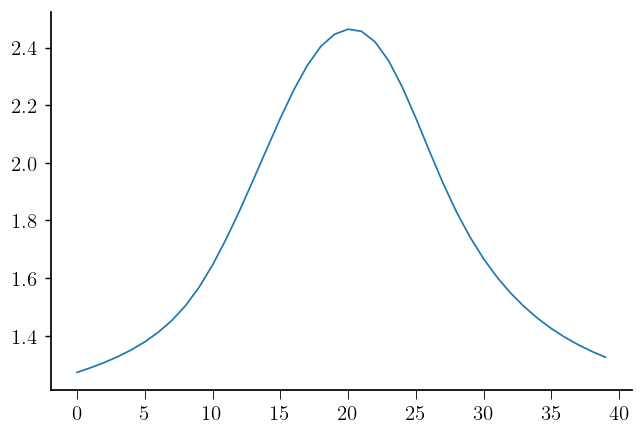

In [766]:
weights_MP = 1 / np.mean(caData1[:,lStart1:lEnd1]/norm_conv, axis=0)
plt.plot(weights_MP)

modelMP = build_conv_model_MP(dl1, redux_ratio)
modelMP.summary()

In [767]:
EPOCHS = 2000

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    modelMP.optimizer = tf.keras.optimizers.Adam(lr=.15, beta_1=0.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)
    
if optimizer == 'SGD': 
    modelMP.optimizer = tf.keras.optimizers.SGD(lr=5e-2, nesterov=True)

history = modelMP.fit((caConvolvedMP)/norm_conv, caData1[:,lStart1:lEnd1]/norm_conv,
                      epochs=EPOCHS, validation_split=0.15 , verbose=2)

Train on 21250 samples, validate on 3750 samples
Epoch 1/2000
21250/21250 - 3s - loss: 0.0180 - mean_absolute_error: 0.0622 - mean_squared_error: 0.0101 - val_loss: 0.0061 - val_mean_absolute_error: 0.0451 - val_mean_squared_error: 0.0034
Epoch 2/2000
21250/21250 - 2s - loss: 0.0055 - mean_absolute_error: 0.0428 - mean_squared_error: 0.0031 - val_loss: 0.0040 - val_mean_absolute_error: 0.0368 - val_mean_squared_error: 0.0023
Epoch 3/2000
21250/21250 - 2s - loss: 0.0045 - mean_absolute_error: 0.0385 - mean_squared_error: 0.0025 - val_loss: 0.0036 - val_mean_absolute_error: 0.0345 - val_mean_squared_error: 0.0020
Epoch 4/2000
21250/21250 - 2s - loss: 0.0039 - mean_absolute_error: 0.0361 - mean_squared_error: 0.0022 - val_loss: 0.0032 - val_mean_absolute_error: 0.0327 - val_mean_squared_error: 0.0018
Epoch 5/2000
21250/21250 - 2s - loss: 0.0036 - mean_absolute_error: 0.0344 - mean_squared_error: 0.0020 - val_loss: 0.0030 - val_mean_absolute_error: 0.0314 - val_mean_squared_error: 0.0017
E

Epoch 43/2000
21250/21250 - 2s - loss: 0.0015 - mean_absolute_error: 0.0229 - mean_squared_error: 8.9538e-04 - val_loss: 0.0013 - val_mean_absolute_error: 0.0207 - val_mean_squared_error: 7.7241e-04
Epoch 44/2000
21250/21250 - 2s - loss: 0.0015 - mean_absolute_error: 0.0226 - mean_squared_error: 8.7735e-04 - val_loss: 0.0013 - val_mean_absolute_error: 0.0206 - val_mean_squared_error: 7.6720e-04
Epoch 45/2000
21250/21250 - 2s - loss: 0.0015 - mean_absolute_error: 0.0228 - mean_squared_error: 8.9468e-04 - val_loss: 0.0013 - val_mean_absolute_error: 0.0205 - val_mean_squared_error: 7.6216e-04
Epoch 46/2000
21250/21250 - 2s - loss: 0.0015 - mean_absolute_error: 0.0225 - mean_squared_error: 8.6452e-04 - val_loss: 0.0013 - val_mean_absolute_error: 0.0205 - val_mean_squared_error: 7.5997e-04
Epoch 47/2000
21250/21250 - 2s - loss: 0.0015 - mean_absolute_error: 0.0225 - mean_squared_error: 8.6869e-04 - val_loss: 0.0013 - val_mean_absolute_error: 0.0204 - val_mean_squared_error: 7.5380e-04
Epoch

Epoch 85/2000
21250/21250 - 2s - loss: 0.0013 - mean_absolute_error: 0.0213 - mean_squared_error: 7.7392e-04 - val_loss: 0.0011 - val_mean_absolute_error: 0.0192 - val_mean_squared_error: 6.6371e-04
Epoch 86/2000
21250/21250 - 2s - loss: 0.0013 - mean_absolute_error: 0.0212 - mean_squared_error: 7.7298e-04 - val_loss: 0.0011 - val_mean_absolute_error: 0.0191 - val_mean_squared_error: 6.6048e-04
Epoch 87/2000
21250/21250 - 2s - loss: 0.0013 - mean_absolute_error: 0.0211 - mean_squared_error: 7.6208e-04 - val_loss: 0.0011 - val_mean_absolute_error: 0.0190 - val_mean_squared_error: 6.5770e-04
Epoch 88/2000
21250/21250 - 2s - loss: 0.0013 - mean_absolute_error: 0.0213 - mean_squared_error: 7.7557e-04 - val_loss: 0.0011 - val_mean_absolute_error: 0.0190 - val_mean_squared_error: 6.5590e-04
Epoch 89/2000
21250/21250 - 2s - loss: 0.0013 - mean_absolute_error: 0.0211 - mean_squared_error: 7.6224e-04 - val_loss: 0.0011 - val_mean_absolute_error: 0.0190 - val_mean_squared_error: 6.5469e-04
Epoch

KeyboardInterrupt: 

(100, 250, 40)
(25000, 20, 1)


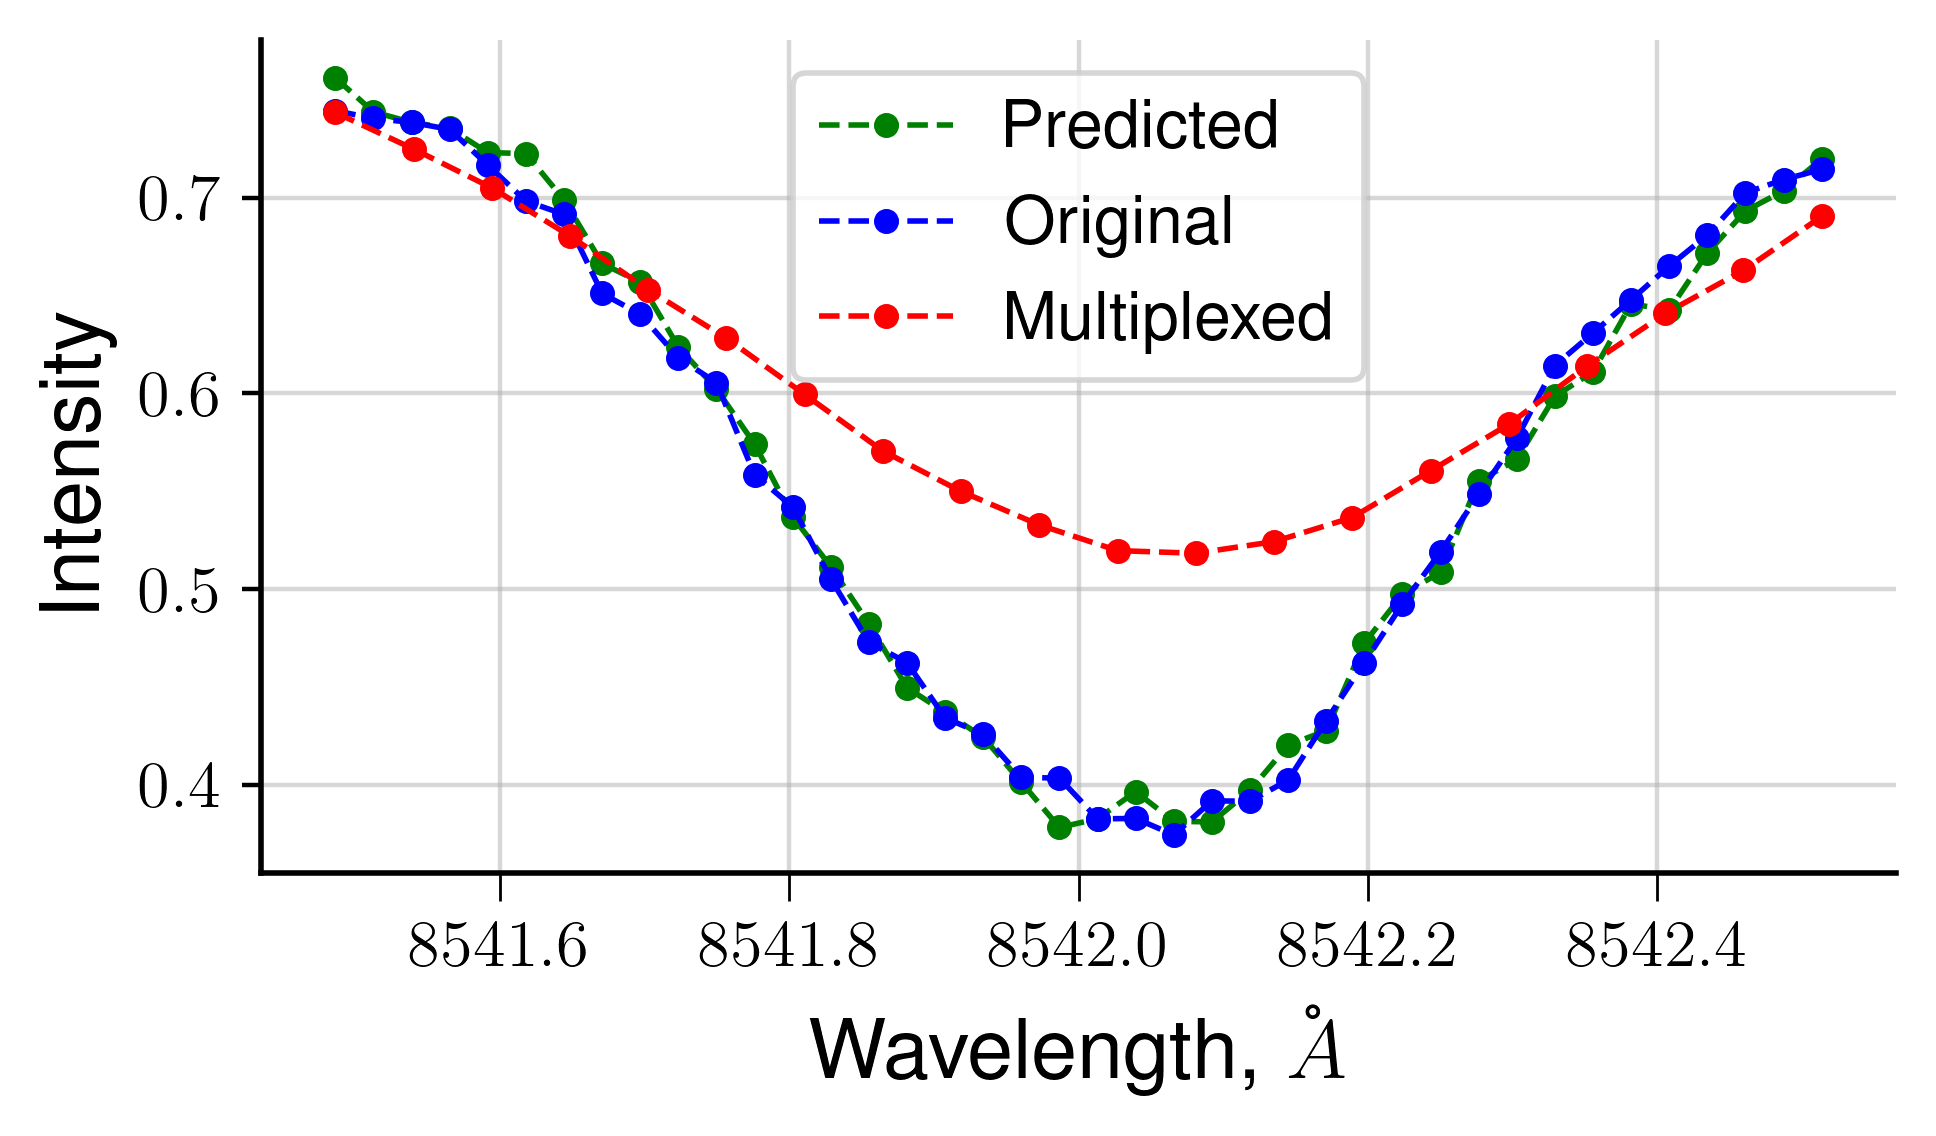

In [769]:
prevNum  = 1100
delta    = 1

dlambda1     = 0.025
markersizex  = 7
print(caData_Conv_norm.shape)
res = modelMP.predict(caConvolvedMP[prevNum:prevNum+delta]/norm_conv)

wavescale  = np.linspace(8542.0-caSpectralRes*dl1/2,
                         8542.0+caSpectralRes*dl1/2, num=dl1)
print(caConvolvedMP.shape)
wavescale1  = np.linspace(8542.0-caSpectralRes*dl1/2,
                         8542.0+caSpectralRes*dl1/2, num=dl1/redux_ratio)
#plot_spec_profile_comparison(wavescale,caConvolvedMP[prevNum:prevNum,:]/5000,
                            #caData1[prevNum:prevNum,::2]/5000,res[0,0:-1:2])
plt.figure(dpi=400,figsize=(5,3))


plt.plot(wavescale,res[0, :], 'g--.', label='Predicted',
         markersize = markersizex)
plt.plot(wavescale,caData1[prevNum,lStart1:lEnd1]/norm_conv, 'b--.',
         label='Original',markersize = markersizex)

plt.plot(wavescale1, (caConvolvedMP[prevNum, :, 0])/norm_conv, 'r--.',
         label='Multiplexed', markersize = markersizex)
plt.grid(alpha=0.5)
plt.xlabel('Wavelength, $\\AA$')
plt.ylabel('Intensity')
plt.legend()
plt.tight_layout()
# plt.savefig('Figures/MP_fail.png',transparent = True)
plt.show()

np.savez('Fig_4_2.npz', wavescale=wavescale, wavescale1=wavescale1,
         caData1=caData1[prevNum,lStart1:lEnd1]/norm_conv, 
         caDataConvolved=(caConvolvedMP[prevNum, :, 0])/norm_conv, res = res[0, :])

(25000,)


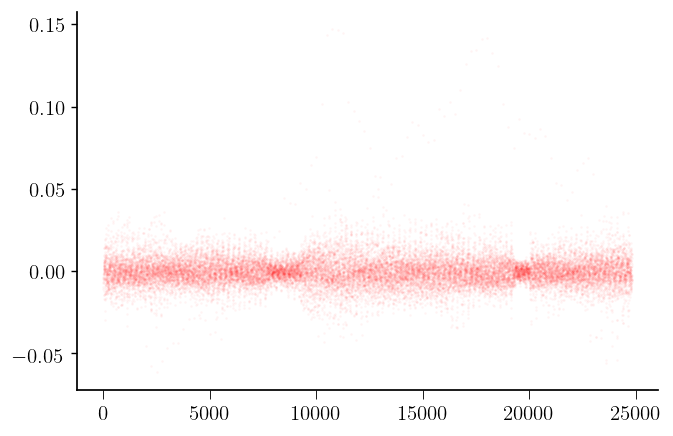

[0.286  0.291  0.2912 ... 0.3758 0.3856 0.3852]
[0.31204328 0.2965988  0.31267008 ... 0.36599204 0.36483967 0.3791977 ]


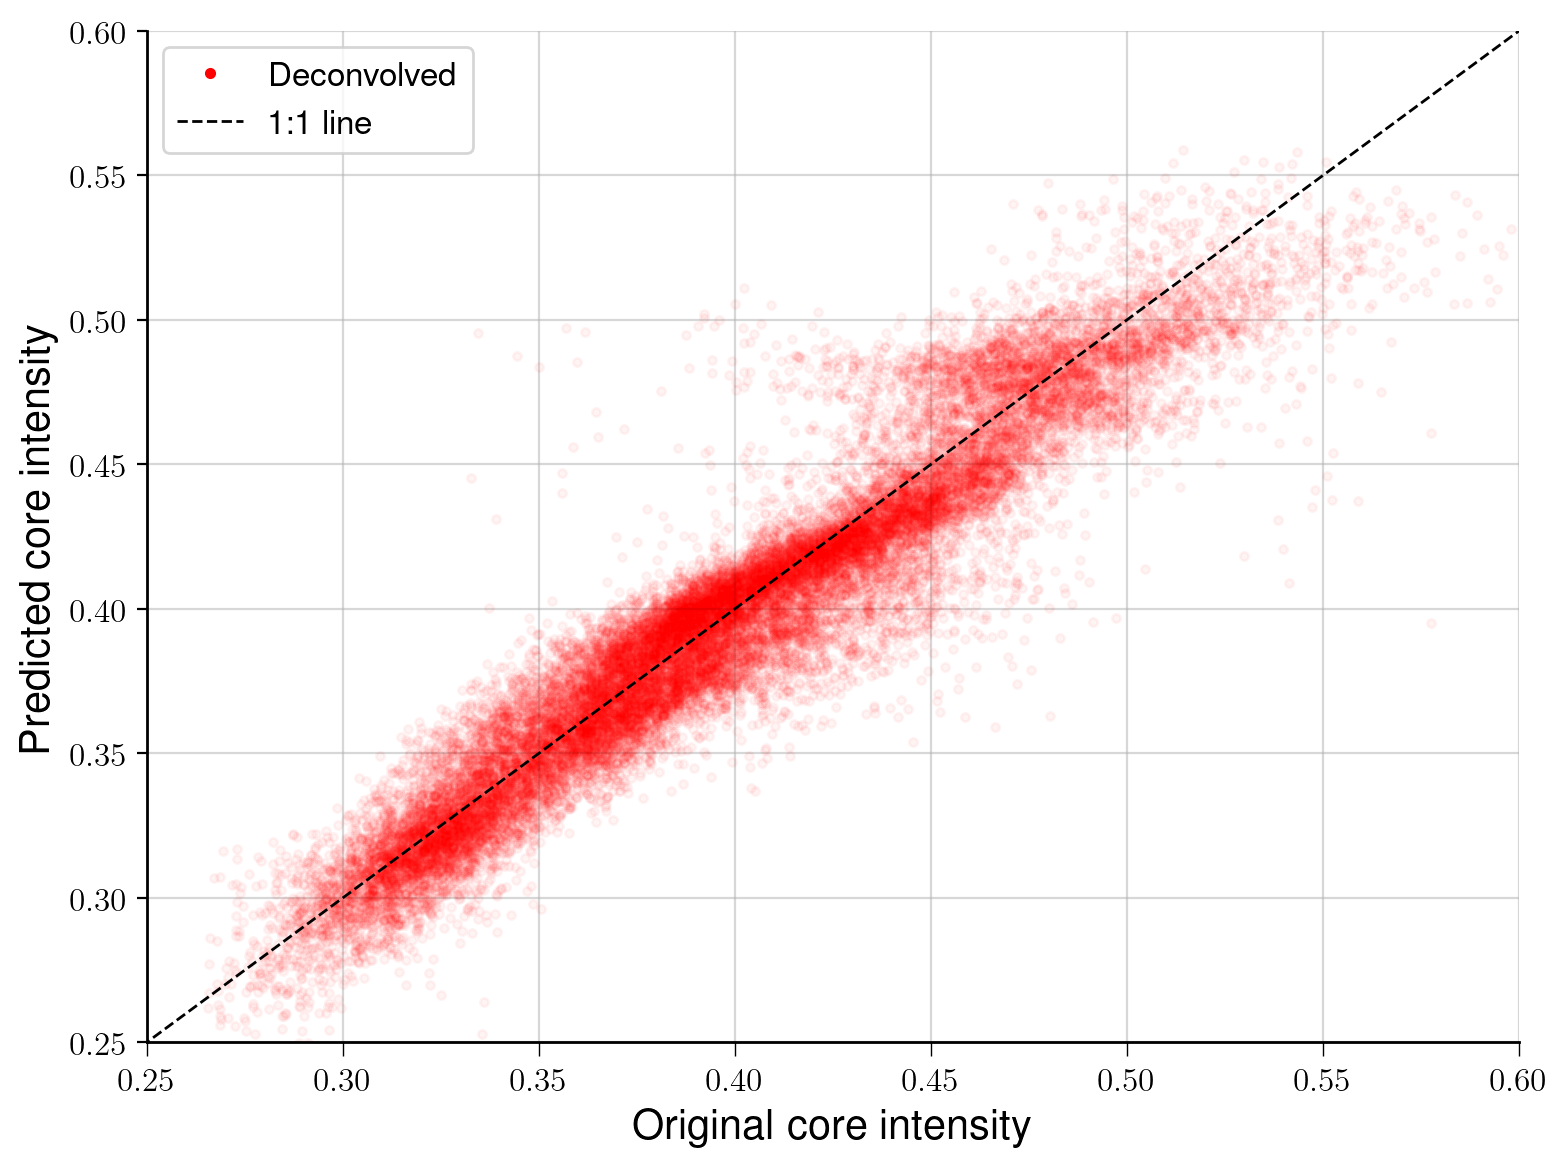

In [770]:
predict = modelMP.predict(caConvolvedMP/norm_conv)
print(np.amin(predict, axis=1).shape)

diff = [np.mean(caConvolvedMP[i,:]/norm_conv 
                - caConvolvedMP[i-1, :]/norm_conv) for i in range(0,24800)]
plt.plot(diff, 'r.', alpha=0.042, markersize = 1)
plt.show()
wavex = np.linspace(np.amin(predict)-.05,np.amax(predict),num=1000)


plt.figure(dpi=200,figsize=(8,6))

print(np.amin(caData1[:, lStart1:lEnd1]/norm_conv, axis=1))
print(np.amin(predict,axis=1))

plt.plot(np.amin(caData1[:, lStart1:lEnd1]/norm_conv, axis=1),
         np.amin(predict,axis=1), 'r.' ,alpha=0.042)
plt.plot(0,0,'r.',label='Deconvolved')

plt.plot(wavex,wavex,'k--',label='1:1 line')

plt.xlabel('Original core intensity')
plt.ylabel('Predicted core intensity')
plt.legend()
plt.xlim(0.25, 0.6)
plt.ylim(0.25, 0.6)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

np.savez('Fig_4_3.npz', caData_all = caData1[:, lStart1:lEnd1], norm_conv=norm_conv,
          predict=predict)

### Estimate the amount of information in the multiplexed data

In [10]:
print(len(caData1[::10,lStart1:lEnd1]))
N_spectra = 2500
print(N_spectra, dl1)
data_array = np.zeros((N_spectra, dl1))
for ii in range(N_spectra):
    data_array[ii, :] = caData1[ii*10,lStart1:lEnd1]/norm_conv
k1 = 2 # start of interval(included)
k2 = 10 # end of interval(included)
intdim_original = Parallel(n_jobs=4)(delayed(intrinsic_dim_sample_wise_parallel)(data_array, k=ii) 
                            for ii in range(5, 200, 5))


  0%|          | 0/5 [00:00<?, ?it/s]

2500
2500 300


/Users/molnarad/CU_Boulder/Work/Chromospheric_business/CNNs/SPSF_remove/intdim_mle.py:42: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)


KeyboardInterrupt: 

(25000, 60, 1)
[5.545165561480785, 5.503053598668585, 5.471262388209364, 5.47410688605965, 5.471093850155439, 5.441866968252401] 5.503053598668585


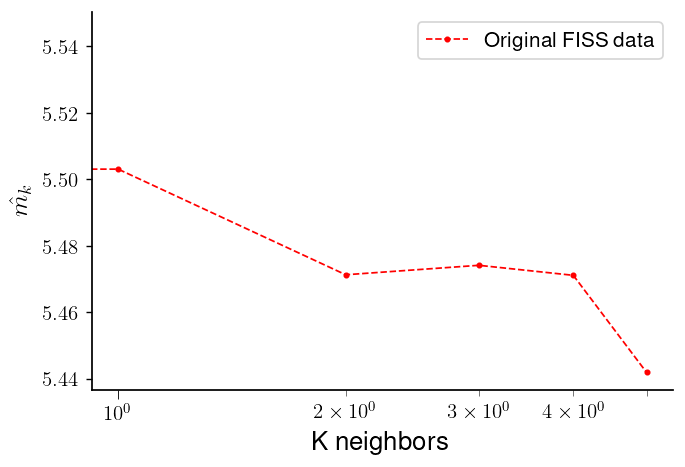

In [24]:
num_k  = 10
k_start= 3
k_end  = 200

intdim_k = []

N_spectra = 3000
print(caConvolvedMP.shape)
data_array = np.zeros((N_spectra, 60))
for ii in range(N_spectra):
    data_array[ii, :] = caConvolvedMP[ii*2,:, 0]/norm_conv

intdim = intrinsic_dim_scale_interval(data_array, k1=5, k2=10)                         
intdim1 = intrinsic_dim_sample_wise_parallel(data_array, k=6)
print(intdim, intdim1)
plt.plot(intdim,'r.--', label='Original FISS data', markersize=5)
plt.xlabel('K neighbors')
plt.ylabel('$\hat{m_k}$')
plt.xscale('log')
plt.legend()
plt.show()

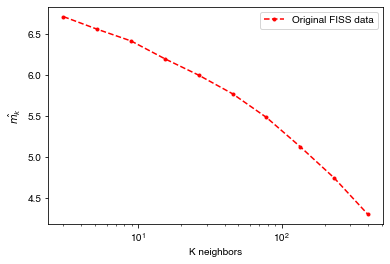

In [16]:
mean_m = np.zeros(num_k)
for jj in range(num_k):
    mean_m[jj] = np.mean(intdim_k[jj][1])

plt.plot(k_values, mean_m,'r.--', label='Original FISS data')
plt.xlabel('K neighbors')
plt.ylabel('$\hat{m_k}$')
plt.xscale('log')
plt.legend()
plt.show()

In [495]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

N_spectra = 12000

def intrinsic_dim_sample_wise_parallel(X, k=5):
    neighb = NearestNeighbors(n_neighbors=(k + 1)).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 1)
    # print(f'd shape is {d.shape}')
    assert d.shape == (X.shape[0],)
    d = np.mean(d)
    
    intdim_sample = 1 / d
    return intdim_sample

num_k  = 25
k0     = 3
k1     = 2000


k_values = np.logspace(np.log10(k0), np.log10(k1), num=num_k)
intdim_k = []


print(N_spectra, dl1)
data_array = np.zeros((N_spectra, int(dl1)))

for ii in range(N_spectra):
    data_array[ii, :] = caData1[ii,lStart1:lEnd1]/norm_conv

intdim_original = Parallel(n_jobs=4)(delayed(intrinsic_dim_sample_wise_parallel)(data_array,
                                                                                 k=int(ii)) 
                            for ii in np.logspace(np.log10(k0), np.log10(k1), num=num_k))

data_array_multi = np.zeros((N_spectra, caConvolvedMP.shape[1]))

for ii in range(N_spectra):
    data_array_multi[ii, :] = caConvolvedMP[ii,:, 0]/norm_conv

intdim_multiplex = Parallel(n_jobs=4)(delayed(intrinsic_dim_sample_wise_parallel)(data_array_multi, k=int(ii)) 
                            for ii in np.logspace(np.log10(k0), np.log10(k1), num=num_k))


12000 30


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


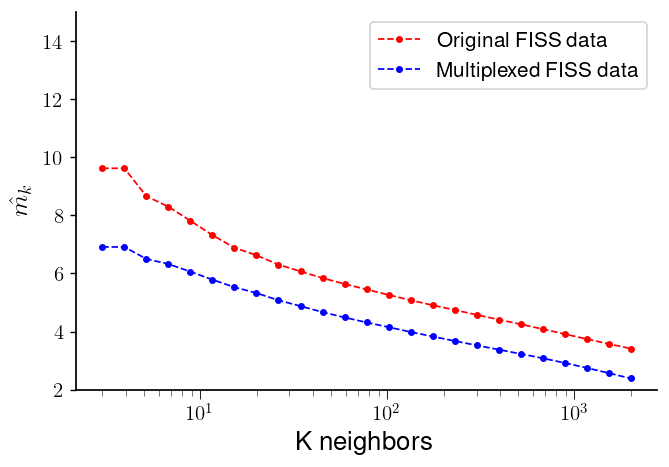

In [560]:
plt.plot(np.logspace(np.log10(k0), np.log10(k1), num=num_k),
         intdim_original, 'r.--', label='Original FISS data')
plt.plot(np.logspace(np.log10(k0), np.log10(k1), num=num_k),
         intdim_multiplex, 'b.--', label='Multiplexed FISS data')

plt.xlabel('K neighbors')
plt.ylabel('$\hat{m_k}$')
plt.xscale('log')
plt.ylim(2, 15)
plt.legend()
plt.show()

waves = np.logspace(np.log10(k0), np.log10(k1), num=num_k)

# np.savez('Fig_4_4.npz', intdim_multiplex=intdim_multiplex,
#         intdim_original=intdim_original, waves=waves)

#### Test case for MLEID metric if it detects one free parameter

Introduce a sub-pixel shift of the same profile and compute the MLEID metric following Asensio Ramos et al., 2007

[[4668 4638 4615 ... 4450 4467 4416]
 [4598 4602 4587 ... 4398 4421 4455]
 [4380 4359 4316 ... 4357 4480 4546]
 ...
 [4447 4459 4379 ... 4291 4285 4359]
 [4450 4453 4449 ... 4367 4283 4292]
 [4638 4620 4592 ... 4469 4423 4397]]
[1.5488131072585931, 1.4029674535057575, 1.2957410648721164, 1.2391377826740861, 1.2081921708146457, 1.1812573865636613, 1.1665072215632597, 1.1452256802665353, 1.137293436771898, 1.1281955349839285, 1.1159594361353526, 1.1043255151367646, 1.0969577483123616, 1.0855967904115227, 1.075008908010138, 1.0708450168827048, 1.0670889668723218, 1.060434252460643, 1.0564321373513093, 1.0542550505411994, 1.0566724252172268, 1.0546333634100962, 1.051935061830734, 1.0497947920274304, 1.0489607408529775, 1.049299062224764, 1.0470648820121982, 1.0463772864986605, 1.04567194397413, 1.0466870946203704, 1.0445706016132512, 1.0444143138505657, 1.0427946659017082, 1.0435937400094342, 1.0418033299773404, 1.0387136757966808, 1.03767644401865, 1.0362229562500354, 1.0374830628465956, 

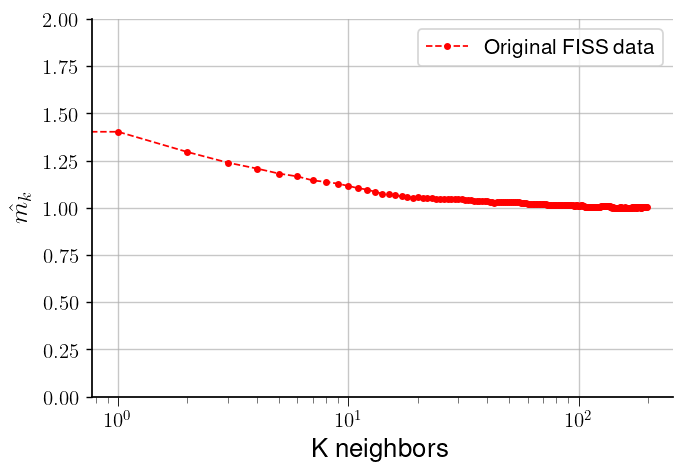

In [75]:
sample_profile = caData[50, 50, 200:330]
sample_profiles = np.array([(shift(sample_profile, np.random.rand()*10))[20:-20] for i in range(1000)])
np.savez('CaProfiles.npz', caData=caData[:, :, 200:330])
print(sample_profiles)
num_k    = 20
k_start  = 3
k_end    = 200


# k_values = np.logspace(np.log10(k0), np.log10(k1), num=num_k)
# intdim_k = []
# intrinsic_dim_sample_wise_parallel(sample_profiles, k=10)
intdim = intrinsic_dim_scale_interval(sample_profiles, k1=k_start, k2=k_end)                         

# intdim = Parallel(n_jobs=4)(delayed(intrinsic_dim_sample_wise_parallel)(sample_profiles, k=ii) 
#                             for ii in range(5, 200, 5))


#for ii in range(k_start, k_end, 10):
#    intdim.append(intrinsic_dim_sample_wise_parallel(np.reshape(caData[:, :, 240:290], (25000, 50)), k=ii))
#intdim = np.array(intdim)

print(intdim)
plt.plot(intdim,'r.--', label='Original FISS data')
plt.xlabel('K neighbors')
plt.ylabel('$\hat{m_k}$')
plt.xscale('log')
plt.grid(alpha=0.7)
plt.legend()
plt.ylim(0, 2)
plt.show()

In [12]:
print(mean_m)

[1.04299945 1.04299945 1.04299945 1.04299945 1.04299945 1.04299945
 1.04299945 1.04299945 1.04299945 1.04299945 1.04299945 1.04299945
 1.04299945 1.04299945 1.04299945 1.04299945 1.04299945 1.04299945
 1.04299945 1.04299945]


In [ ]:
# TProfile -- transmission profile
# caConvolved[80, 20, lStart:lEnd]
# caData[80, 20, lStart:lEnd]

minTP = np.amin(TProfile)
TProfile_min = TProfile[240:-240]
print(f"TProfile dimensions are {TProfile_min.shape}")
for ii in range(len(TProfile_min)):
    if TProfile_min[ii] == 0:
        TProfile_min[ii] = 1e-3

plt.plot(TProfile_min)
plt.show()
        
print(f'shape of caData is {caData.shape}')
print(f'shape of caConvolved is {caConvolved.shape}')
plt.plot(caData[80, 20, lStart:lEnd], 'r.--', label='Original Data')
plt.plot(caConvolved[80, 20, lStart:lEnd], 'b.--', label='Convolved')

N_trials = 25000
start = time.process_time()
for ii in range(250):
    for jj in range(100):
        recovered, remainder = deconvolve(caConvolved[jj, ii, :], TProfile_min)
print(f"The elapsed time for {N_trials} inversion is {time.process_time() - start}")

plt.plot(recovered[lStart:lEnd], 'g.--', label='Recovered')
plt.ylim(np.amin(caConvolved[jj, ii, lStart:lEnd])*.5, np.amax(caConvolved[jj, ii, lStart:lEnd])*2)
plt.legend()
plt.show()


In [1]:
cont_index = 1
core_index = 256

fig, ax = plt.subplots(2,1)
fig.set_dpi(200)
fig.set_size_inches(6,4)
ax[0].imshow(caData[:,:,cont_index],cmap='hot',
             vmax=np.amax(caData[:,:,cont_index]),vmin=np.amin(caData[:,:,cont_index])*1.3)
ax[0].set_title('Continuum image')
ax[0].set_xticklabels([])
ax[0].set_ylabel('Solar Y, [pixels]')

ax[1].imshow(caData[:,:,core_index],cmap='gray',
             vmax=np.amax(caData[:,:,core_index]),vmin=np.amin(caData[:,:,core_index])*1.)
ax[1].set_title('8542 $\\AA$ line core Intensity')
ax[1].set_xlabel('Solar X, [pixels]')
ax[1].set_ylabel('Solar Y, [pixels]')

plt.tight_layout()

plt.savefig('Figures/FISS_FOV.png',transparent=True)
plt.show()

NameError: name 'plt' is not defined

The elapsed time for 250 inversion is 1.9011200000004465


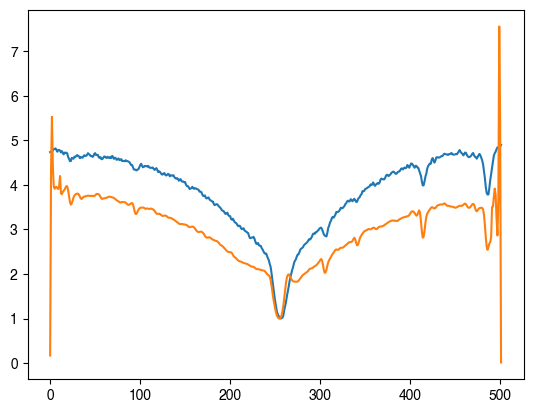

In [185]:
from skimage import color, data, restoration
TProfile_multiD = np.zeros((10, 25, 22))
for ii in range(10):
    for jj in range(25):
        TProfile_multiD[ii, jj, :] = TProfile_min[:]
start = time.process_time()
DL = restoration.richardson_lucy(caData[0:10, 0:25, :], TProfile_multiD, iterations=30)
print(f"The elapsed time for 250 inversion is {time.process_time() - start}")

plt.plot(caData[8,8,:]/np.amin(caData[8,8,100:300]))
plt.plot(DL[8,8,:]/np.amin(DL[8,8,100:300]))
plt.show()